<p>Untill now we have seen only two probability distributions binomial and  Uniform.
This chapter introduces linear regression as a Bayesian procedure. Under a probability
interpretation, which is necessary for Bayesian work, linear regression uses a Gaussian (normal)
distribution to describe our model's uncertainty about some measurement of interest.
This type of model is simple, flexible, and commonplace. Like all statistical models, it is
not universally useful. But linear regression has a strong claim to being foundational, in the sense that once you learn to build and interpret linear regression models, you can more easily
move on to other types of regression which are less normal.</p>


<h1>Why normal distributions are normal</h1>
Suppose you and a thousand of your closest friends line up on the halfway line of a soccer field (football pitch). Each of you has a coin in your hand. At the sound of the whistle, you
begin flipping the coins. Each time a coin comes up heads, that person moves one step
towards the left-hand goal. Each time a coin comes up tails, that person moves one step
towards the right-hand goal. Each person flips the coin 16 times, follows the implied moves,
and then stands still. Now we measure the distance of each person from the halfway line.
Can you predict what proportion of the thousand people who are standing on the halfway
line? How about the proportion 5 yards left of the line?
It’s hard to say where any individual person will end up, but you can say with great confidence
what the collection of positions will be. The distances will be distributed in approximately
normal, or Gaussian, fashion. This is true even though the underlying distribution is
binomial. It does this because there are so many more possible ways to realize a sequence of
left-right steps that sums to zero. There are slightly fewer ways to realize a sequence that ends
up one step left or right of zero, and so on, with the number of possible sequences declining
in the characteristic bell curve of the normal distribution.



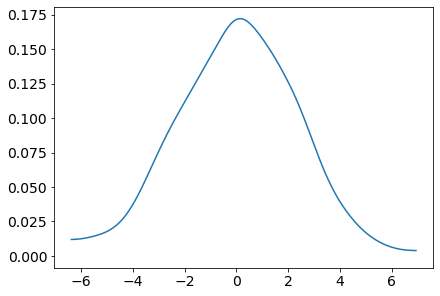

In [23]:
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
pos = np.random.uniform(-1, 1, size=(16, 1000)).sum(0)
pm.kdeplot(pos);

<h2>NORMAL by Addition</h2>
Any process that adds together random values from the same distribution converges to
a normal. But it’s not easy to grasp why addition should result in a bell curve of sums.64
Here’s a conceptual way to think of the process. Whatever the average value of the source
distribution, each sample from it can be thought of as a fluctuation from that average value.
When we begin to add these fluctuations together, they also begin to cancel one another out.
A large positive fluctuation will cancel a large negative one. The more terms in the sum, the
more chances for each fluctuation to be canceled by another, or by a series of smaller ones
in the opposite direction. So eventually the most likely sum, in the sense that there are the most ways to realize it, will be a sum in which every fluctuation is canceled by another, a sum
of zero (relative to the mean).
It doesn’t matter what shape the underlying distribution possesses. It could be uniform,
like in our example above, or it could be (nearly) anything else.Depending upon the underlying
distribution, the convergence might be slow, but it will be inevitable.

<h2>Normal by multiplication.</h2>
 Suppose the growth rate of an organism is influenced by a dozen loci, each with several alleles that
code for more growth. Suppose also that all of these loci interact with one another, such that
each increase growth by a percentage. This means that their effects multiply, rather than add.

<p>This code just samples 12 random numbers between 1.0 and 1.1, each representing a proportional
increase in growth. Thus 1.0 means no additional growth and 1.1 means a 10%
increase. The product of all 12 is computed and returned as output. Now what distribution
do you think these random products will take? Let’s generate 10,000 of them and see:</p>

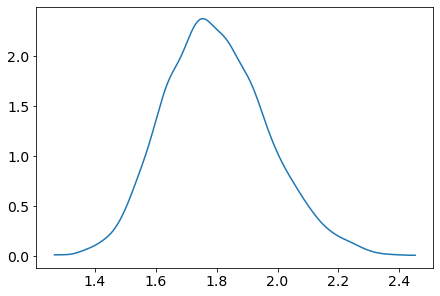

In [28]:
pos = np.random.uniform(1, 1.1, size=(12, 10000)).prod(0)
pm.kdeplot(pos);

<h2>Normal by log-multiplication.</h2>  Large deviates that are multiplied
together do not produce Gaussian distributions, but they do tend to produce Gaussian
distributions on the log scale.

In [29]:
log_big = np.log(np.random.uniform(1, 1.5, size=(12, 10000)).prod(0))
log_big

array([2.49842248, 2.51343614, 2.39810096, ..., 3.17308295, 2.83722712,
       2.70821187])

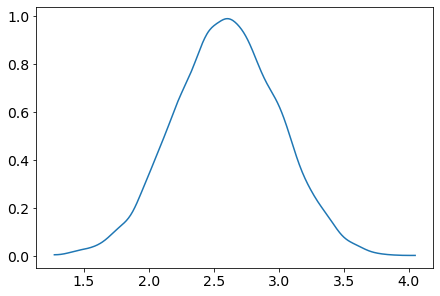

In [30]:
pm.kdeplot(log_big);

<h1>Gaussian Model of Height <h1>

array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'male'}>]], dtype=object)

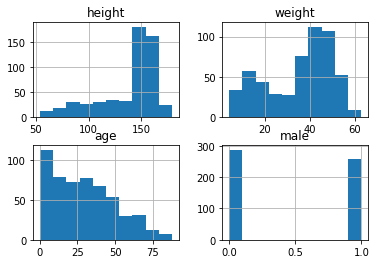

In [34]:
import pandas as pd
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
d.hist()

All we want for now are heights of adults in the sample. The reason to filter out nonadults
for now is that height is strongly correlated with age, before adulthood

In [35]:
d2 = d[d.age >= 18]

array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'weight'}>],
       [<AxesSubplot:title={'center':'age'}>,
        <AxesSubplot:title={'center':'male'}>]], dtype=object)

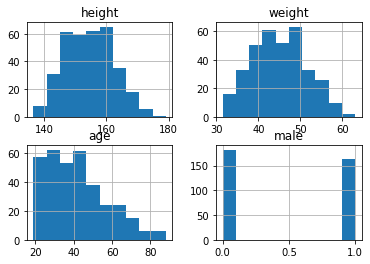

In [36]:
df2.hist()

<p>Adult heights from a single population are nearly always approximately normal. ( bimodel if you take gender in account).So it’s reasonable for the moment to adopt the stance that the model should use a Gauss- ian distribution for the probability distribution of the data. </p>
<p>So which Gaussian distribution? There are an infinite number of them, with an infinite number of different means and standard deviations. We’re ready to write down the general model and compute the plausibility of each combination of μ and σ. To define the heights as normally distributed with a mean μ and standard deviation σ, we write:</p>

$$ h_i ∼ Normal(μ, σ)$$

What are the priors

$$μ ∼ Normal(167, 20)$$

$$ σ ∼ Uniform(0, 50)$$


<p>The prior for μ is a broad Gaussian prior, centered on 167cm,
with 95% of probability between 167 ± 40.</p>
<p>
Why  167 cm? Your author is 167 cm tall. And the range from 127 cm to 207 cm encompasses
a huge range of plausible mean heights for human populations. So domain-specific
information has gone into this prior. Everyone knows something about human height and
can set a reasonable and vague prior of this kind. But in many regression problems,  using prior information is more subtle, because parameters don’t always have such
clear physical meaning.</p>
<p>
The σ prior is a truly flat prior, a uniform one, that functions
just to constrain σ to have positive probability between zero and 50cm.</p>
    <p>A standard deviation like σ must be positive, so bounding it at zero makes sense. How should
we pick the upper bound? In this case, a standard deviation of 50cm would imply that 95%
of individual heights lie within 100cm of the average height. That’s a very large range.
    </p>

<h1>the model </h1>



In [37]:
with pm.Model() as normalheightmodel:
    mu = pm.Normal('mu', mu=167, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=d2.height)
    prior_checks = pm.sample_prior_predictive(samples=50)

In [38]:
prior_checks

{'mu': array([161.68568447, 169.07315489, 169.93059488, 147.24764129,
        156.30268377, 180.18805626, 195.51565475, 193.50249961,
        191.77610359, 142.01224671, 176.63414853, 167.48131151,
        157.98976092, 159.64549275, 155.06915017, 158.26051686,
        173.34874796, 204.75530834, 164.1460091 , 163.30126147,
        186.27204596, 172.16226974, 204.0714821 , 127.93455126,
        177.58122013, 165.13197172, 206.09510283, 156.6734143 ,
        164.75878526, 168.7757277 , 163.10856776, 180.11488304,
        169.78602245, 179.91749418, 202.94436376, 159.73856046,
        198.10480797, 190.47248519, 179.64793924, 176.51466836,
        142.81406147, 188.93446253, 168.17935138, 168.31661762,
        154.28949786, 150.29289677, 162.20515033, 140.23328729,
        146.00480057, 129.3191801 ]),
 'sigma': array([37.29511838, 45.82380528, 27.21105435,  8.66118465, 46.19606049,
         7.8302595 , 40.53809889,  6.36248074,  4.02099717, 14.26266465,
        47.41899741,  2.28154474,

<h1>prior predictive simulation<h1>


<p>It will help to really see what these priors imply about the distribution
of individual heights. This is an essential part of your modeling, the prior predictive
simulation. Once you’ve chosen priors for h, μ, and σ, these imply a joint prior distribution
of individual heights.</p><p> By simulating from this distribution, you can see what your choices
imply about observable height. This helps you diagnose bad choices. Lots of conventional
choices are indeed bad ones, and we’ll be able to see this by conducting prior predictive simulations</p>

prior_checks = pm.sample_prior_predictive(samples=50)

In [40]:
simulatedheihgts=pd.DataFrame(prior_checks['height'])
simulatedheihgts

,0,1,2,3,4,5,6,7,8,9,...,342,343,344,345,346,347,348,349,350,351
0,120.062468,165.280697,173.166020,119.746474,188.385089,239.145717,190.917189,148.947511,197.477665,199.473697,...,150.609503,145.293277,127.829641,145.999942,116.229219,169.656578,111.071138,170.498411,174.039040,209.245648
1,211.918424,172.707752,68.367786,181.644348,179.943693,104.278046,260.350415,160.406985,189.773161,176.639734,...,221.177913,135.503984,156.757111,122.802313,112.502296,146.070051,118.686941,190.103055,184.876462,115.029694
2,138.382757,196.173987,173.101383,189.237781,155.485267,167.059099,165.954858,194.071527,159.209208,190.788091,...,182.546963,137.072362,178.354803,177.522751,214.175590,163.698183,169.005807,205.571061,183.338854,119.264743
3,126.239955,140.396502,137.116536,153.758692,140.628000,155.799431,147.274069,132.017448,148.078108,132.597908,...,143.175068,135.295048,137.344927,149.261736,157.488156,153.802862,138.181934,162.910634,138.886319,156.068435
4,81.497796,132.924215,131.447576,160.374503,180.503039,65.195441,115.146784,181.015961,215.133319,145.754080,...,209.506758,153.302797,134.856328,188.158055,175.408830,90.018323,84.030944,221.043148,212.757891,207.406405
5,171.380845,172.512873,185.912706,184.527339,172.981128,185.487900,172.972531,181.944627,165.617538,178.799827,...,187.993502,173.518647,178.917758,168.168854,173.240020,178.587431,189.202226,191.294593,190.907565,189.467082
6,192.899868,184.662697,158.032016,202.828508,127.250051,214.830750,218.899938,160.265246,227.491589,269.911129,...,212.600149,162.989695,186.784048,215.693612,170.774349,189.083647,174.698363,167.016423,280.560193,139.934403
7,197.455175,193.961184,187.007099,191.618311,188.473761,180.648798,195.275478,188.300931,197.908705,190.968742,...,182.118253,203.539760,195.563167,184.806712,188.489575,212.098180,196.793971,198.264887,186.671939,192.558685
8,190.157575,194.998228,191.079129,192.339919,186.203214,188.875492,192.718471,194.505427,190.140530,192.149387,...,189.951325,194.998549,193.398852,184.362254,187.151242,192.872632,187.782155,195.124477,189.528422,194.814561
9,157.826208,140.131117,123.562357,173.481397,142.733384,168.077795,156.819017,141.121533,150.965462,147.449298,...,137.485199,124.319481,144.476165,139.314998,153.333166,154.902690,125.460722,155.022200,149.877308,167.698688


In [41]:
priorDF=pd.DataFrame()
for key, value in prior_checks.items():
   if (key !='height'):
        priorDF[key]=value
priorDF.head()   

,mu,sigma,sigma_interval__
0,161.685684,37.295118,1.076876
1,169.073155,45.823805,2.395403
2,169.930595,27.211054,0.177348
3,147.247641,8.661185,-1.562950
4,156.302684,46.196060,2.496857


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'sigma_interval__'}>,
        <AxesSubplot:>]], dtype=object)

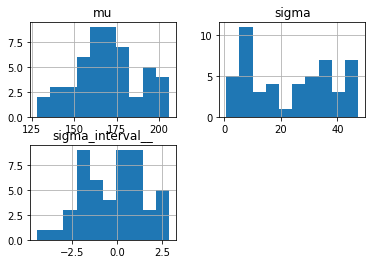

In [42]:
priorDF.hist()

In [43]:
simulatedheihgts.min()

0       81.497796
1       61.965206
2       68.367786
3      101.429916
4        3.448899
          ...    
347     81.687040
348     84.030944
349    103.450838
350     79.765021
351     62.062239
Length: 352, dtype: float64

BAD choices

<AxesSubplot:>

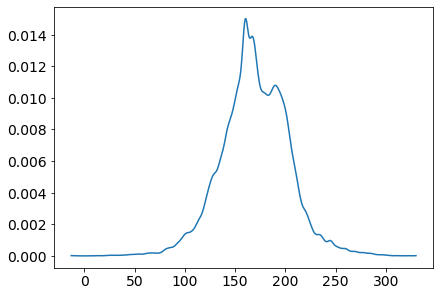

In [44]:
az.plot_kde((prior_checks['height']))

<AxesSubplot:>

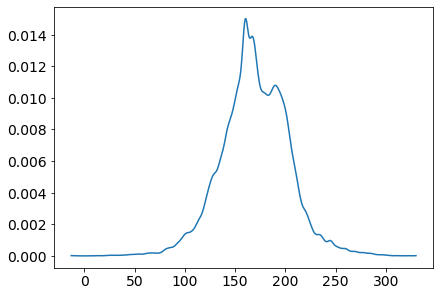

In [45]:
mu_posterior = np.concatenate(prior_checks['height'])
mu_posterior.shape
az.plot_kde(mu_posterior)

In [1]:
import arviz as az
import pymc3 as pm
import pandas as pd
import numpy as np
import xarray
xarray.set_options(display_style="html");

In [6]:
d = pd.read_csv('Data/Howell1.csv', sep=';', header=0)
df2=d[d.age>18]
d.head()
df2.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041915,41.0,1
4,145.415,41.276872,51.0,0


In [10]:
#read data

height = df2.height.values
weight = df2.weight.values
age = df2.age.values
names = df2.index.values
N = len(names)


In [46]:
dims={
    "height": ["developer"],
    "wight": ["developer"],
    "age": ["developer"],
}
with pm.Model() as model:
    
    
    mu = pm.Normal('mu', mu=167, sd=20)
    sigma = pm.Uniform('sigma', lower=0, upper=50)
    height = pm.Normal('height', mu=mu, sd=sigma, observed=df2.height)
    
    # BUİLDS PRIOR PREDICTİVE DIST
    
    trace = pm.sample(400, chains=4)# CREATES SAMPLES FROM POSTERIOR DISTRIBUTION
    posterior_predictive = pm.sample_posterior_predictive(trace)# CREATES POSTERIOR PREDICTIVE
                                                                  #CHECKS
    prior = pm.sample_prior_predictive(150) # BUİLDS PRIOR PREDICTİVE DIST
   
    idata_pymc3 = az.from_pymc3(    # FOR ARVIZ USAGE
        trace,
        prior=prior,
        posterior_predictive=posterior_predictive,
        coords={"developer": names},
        dims=dims
    )

Only 400 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [sigma, mu]


Sampling 4 chains for 1_000 tune and 400 draw iterations (4_000 + 1_600 draws total) took 49 seconds.


0, dim: developer, 346 =? 346


/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([[<AxesSubplot:title={'center':'mu'}>,
        <AxesSubplot:title={'center':'mu'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>]], dtype=object)

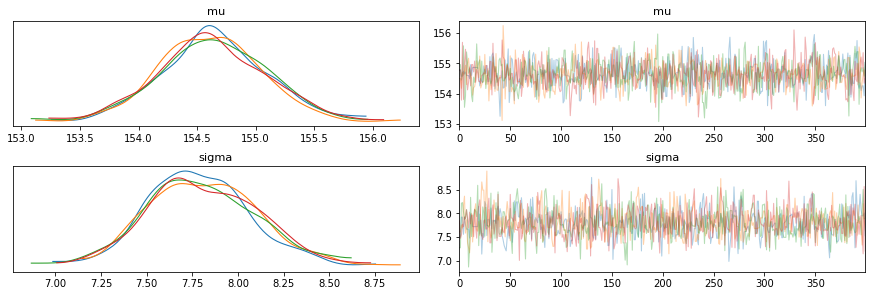

In [47]:
az.plot_trace(trace) #plot trace and hist=kde

<AxesSubplot:xlabel='height'>

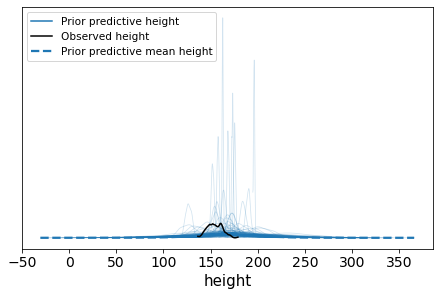

In [48]:
    az.plot_ppc(idata_pymc3 ,group='prior') # plot prior predictive dist

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:87: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


array([<AxesSubplot:title={'center':'mu'}>,
       <AxesSubplot:title={'center':'sigma'}>], dtype=object)

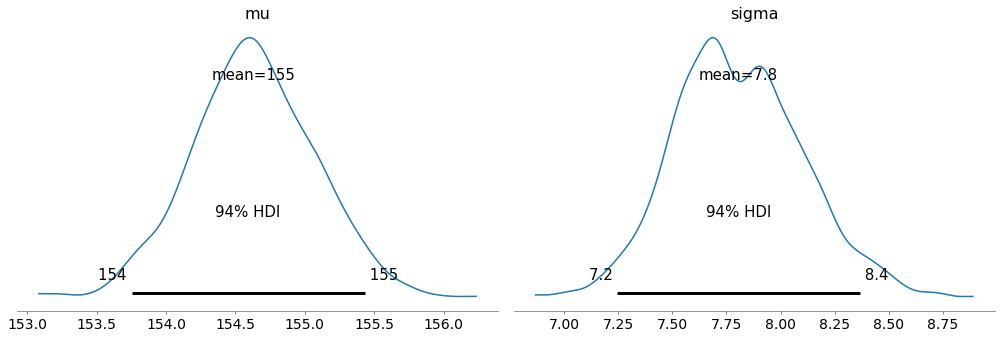

In [49]:
az.plot_posterior(trace) # plot posterior distributıon after seing data

<AxesSubplot:xlabel='height'>

/Users/gokhansahin/opt/anaconda3/envs/MCelreath-pymc3/lib/python3.8/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


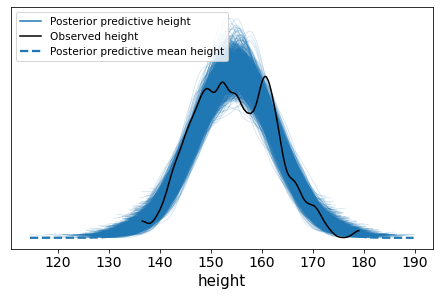

In [50]:
    az.plot_ppc(idata_pymc3 ,group='posterior')#posterior predictive dist